<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/machine-learning-bookcamp/1_car_price_prediction_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Car-price prediction project

Suppose that we
have a website where people can sell and buy used cars. When posting an ad on our
website, sellers often struggle to come up with a meaningful price. We want to help
our users with automatic price recommendations. 

We ask the sellers to specify the
model, make, year, mileage, and other important characteristics of a car, and based on
that information, we want to suggest the best price.

##Setup

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
# content/gdrive/My Drive/Kaggle is the path where kaggle.json is  present in the Google Drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle-keys"

In [ ]:
%%shell

# download dataset from kaggle> URL: https://www.kaggle.com/datasets/CooperUnion/cardataset
kaggle datasets download -d CooperUnion/cardataset

unzip -qq cardataset.zip
rm -rf cardataset.zip

##Dataset

In [5]:
# let’s read our dataset
df = pd.read_csv("data.csv")
len(df)

11914

In [6]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [7]:
# Let's normalize the column names
df.columns = df.columns.str.lower().str.replace(" ", "_")  
string_columns = list(df.dtypes[df.dtypes == "object"].index)
for col in string_columns:
  df[col] = df[col].str.lower().str.replace(" ", "_")

In [8]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


##Exploratory data analysis

###Target variable analysis

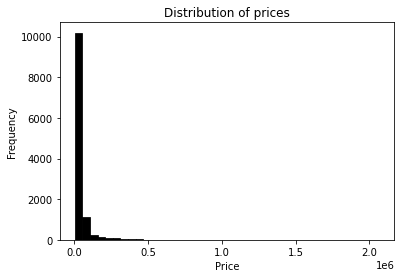

In [9]:
# let's analyze the target variable
plt.figure(figsize=(6, 4))

sns.histplot(df.msrp, bins=40, color="black", alpha=1)
plt.ylabel("Frequency")
plt.xlabel("Price")
plt.title("Distribution of prices")
plt.show()

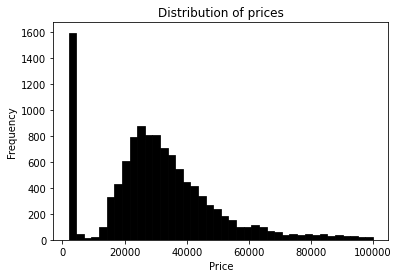

In [10]:
# a closer look by zooming in a bit and looking at values below $100,000
plt.figure(figsize=(6, 4))

sns.histplot(df.msrp[df.msrp < 100000], bins=40, color="black", alpha=1)
plt.ylabel("Frequency")
plt.xlabel("Price")
plt.title("Distribution of prices")
plt.show()

The long tail makes it quite difficult for us to see the distribution, but it has an even
stronger effect on a model: such distribution can greatly confuse the model, so it
won’t learn well enough. 

One way to solve this problem is log transformation. If we
apply the log function to the prices, it removes the undesired effect.

$$y_{new} = log(y + 1)$$

The +1 part is important in cases that have zeros. 

The logarithm of zero is minus infinity,
but the logarithm of one is zero.

If our values are all non-negative, by adding 1, we
make sure that the transformed values do not go below zero.

In [11]:
np.log(1)

0.0

In [12]:
np.log(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

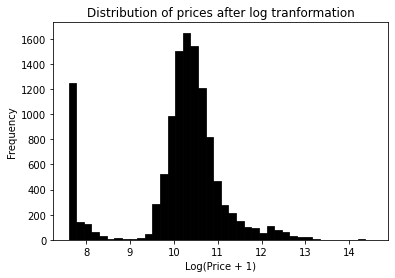

In [13]:
log_price = np.log1p(df.msrp)

plt.figure(figsize=(6, 4))

sns.histplot(log_price, bins=40, color="black", alpha=1)
plt.ylabel("Frequency")
plt.xlabel("Log(Price + 1)")
plt.title("Distribution of prices after log tranformation")
plt.show()

As we see, this transformation removes the long tail, and now the distribution resembles
a bell-shaped curve. 

This distribution is not normal, of course, because of the
large peak in lower prices, but the model can deal with it more easily.

###Checking for missing values

In [14]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

###Splitting Dataset

In [15]:
# Splitting Data into validation, test, and training sets
np.random.seed(2)

n = len(df)

# Calculates how many rows should go to train, validation, and test
n_val = int(.2 * n)
n_test = int(.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

# Splits the shuffled DataFrame into train, validation, and test
df_train = df_shuffled.iloc[: n_train].copy()
df_val = df_shuffled.iloc[n_train: n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val: ].copy()

In [16]:
# let's take a smaller array of five elements and shuffle it
idx = np.arange(5)
print(f"before shuffle {idx}")
np.random.shuffle(idx)
print(f"after shuffle {idx}")

before shuffle [0 1 2 3 4]
after shuffle [1 2 0 4 3]


In [17]:
np.random.seed(2)
idx = np.arange(5)
print(f"before shuffle {idx}")
np.random.shuffle(idx)
print(f"after shuffle {idx}")

before shuffle [0 1 2 3 4]
after shuffle [2 4 1 3 0]


In [18]:
# let's apply the log transformation to target variable
y_train_orig = df_train.msrp.values
y_val_orig  = df_val.msrp.values
y_test_orig = df_test.msrp.values

y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

del df_train["msrp"]
del df_val["msrp"]
del df_test["msrp"]

##Linear Regression

Let's implement the normal equation.

$$
w = (X^TX)^{-1} X^T y
$$

In [19]:
def train_linear_regression(X, y):
  # adding dummy feature into X
  ones = np.ones(X.shape[0])
  X = np.column_stack([ones, X])

  XTX = X.T.dot(X)
  XTX_inv = np.linalg.inv(XTX)
  w = XTX_inv.dot(X.T).dot(y)
  # Splits the weights vector into the bias and the rest of the weights
  return w[0], w[1:]

###Baseline solution

In [20]:
# Let’s select the numerical features from the data frame
features_base = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg", "popularity"]

In [21]:
def prepare_data_set(df):
  df_num = df[features_base]  # selecting numerical features
  df_num = df_num.fillna(0)   # filling the missing values with zero
  X = df_num.values           # converting the DataFrame to a NumPy array
  return X

x_train = prepare_data_set(df_train)

In [22]:
# let's train the model
w_0, w = train_linear_regression(x_train, y_train)

In [23]:
# let's see how well it predicts
y_pred = w_0 + x_train.dot(w)

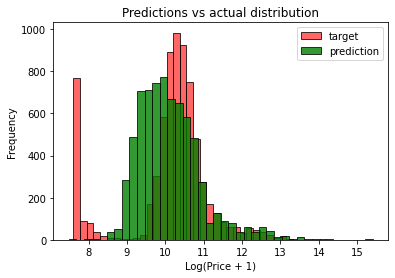

In [24]:
# let's plot the actual and predicted distribution
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label="target", color="red", alpha=0.6, bins=40)
sns.histplot(y_pred, label="prediction", color="green", alpha=0.8, bins=40)

plt.legend()
plt.xlabel("Log(Price + 1)")
plt.ylabel("Frequency")
plt.title("Predictions vs actual distribution")
plt.show()

As we can see that the distribution of values we predicted
looks quite different from the actual values. 

This result may indicate that the model is
not powerful enough to capture the distribution of the target variable. 

This shouldn’t be a surprise to us: the model we used is quite basic and includes only five very simple features.

###Evaluating the model

In [25]:
# let's define root mean squared error
def rmse(y, y_pred):
  error = y_pred - y
  mse = (error ** 2).mean()
  return np.sqrt(mse)

In [26]:
# let's evaluate the quality of the model
rmse(y_train, y_pred)

0.7554192603920132

###Validating the model

In [27]:
# let's apply the model to the validation dataset
x_val = prepare_data_set(df_val)
y_pred = w_0 + x_val.dot(w)

# Let's computes RMSE on the validation data
print(f"validation: {str(rmse(y_val, y_pred))}")

validation: 0.761653099130156


This gives us a way to check whether any model adjustments lead to improvements in
the predictive quality of the model.

##Feature engineering

In [28]:
def prepare_data_set(df):
  df = df.copy()
  features = features_base.copy()

  # Computes the age feature
  df["age"] = 2017 - df.year
  features.append("age")

  df_num = df[features]       # selecting features
  df_num = df_num.fillna(0)   # filling the missing values with zero
  X = df_num.values           # converting the DataFrame to a NumPy array
  return X

In [29]:
# Let’s test if adding the feature “age” leads to any improvements
x_train = prepare_data_set(df_train)
w_0, w = train_linear_regression(x_train, y_train)

y_pred = w_0 + x_train.dot(w)
print(f"train: {rmse(y_train, y_pred)}")

x_val = prepare_data_set(df_val)
y_pred = w_0 + x_val.dot(w)
print(f"validation: {rmse(y_val, y_pred)}")

train: 0.5175055465840046
validation: 0.5172055461058299


The validation error is 0.517, which is a good improvement from 0.76 — the value we
had in the baseline solution. 

Thus, we conclude that adding “age” is indeed helpful
when making predictions.

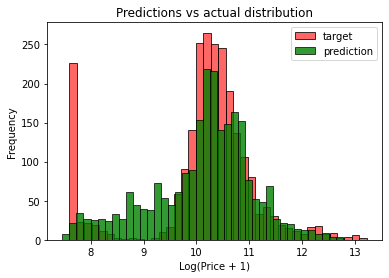

In [30]:
# We can also look at the distribution of the predicted values
plt.figure(figsize=(6, 4))

sns.histplot(y_val, label="target", color="red", alpha=0.6, bins=40)
sns.histplot(y_pred, label="prediction", color="green", alpha=0.8, bins=40)

plt.legend()
plt.xlabel("Log(Price + 1)")
plt.ylabel("Frequency")
plt.title("Predictions vs actual distribution")
plt.show()

We see that the distribution of the predictions follows the target distribution
a lot more closely than previously. 

Indeed, the validation RMSE score confirms it.

###Handling categorical variables

In [31]:
# Let’s find out what the five most frequent make values are
df["make"].value_counts().head(5)

chevrolet     1123
ford           881
volkswagen     809
toyota         746
dodge          626
Name: make, dtype: int64

In [32]:
# Handling categorical variables number of doors and make
def prepare_data_set(df):
  df = df.copy()
  features = features_base.copy()

  # Computes the age feature
  df["age"] = 2017 - df.year
  features.append("age")

  # Encodes the number of doors variable
  for v in [2, 3, 4]:
    feature = f"num_doors_{v}"
    df[feature] = (df["number_of_doors"] == v).astype(int)
    features.append(feature)
  
  # Encodes the make variable
  for v in ["chevrolet", "ford", "volkswagen", "toyota", "dodge"]:
    feature = f"is_make_{v}"
    df[feature] = (df["make"] == v).astype(int)
    features.append(feature)

  df_num = df[features]       # selecting features
  df_num = df_num.fillna(0)   # filling the missing values with zero
  X = df_num.values           # converting the DataFrame to a NumPy array
  return X

In [33]:
# Let’s check whether this improves the RMSE of the model
x_train = prepare_data_set(df_train)
w_0, w = train_linear_regression(x_train, y_train)

y_pred = w_0 + x_train.dot(w)
print(f"train: {rmse(y_train, y_pred)}")

x_val = prepare_data_set(df_val)
y_pred = w_0 + x_val.dot(w)
print(f"validation: {rmse(y_val, y_pred)}")

train: 0.5058876515487503
validation: 0.5076038849556795


The previous value was 0.517, so we managed to improve the RMSE score further.

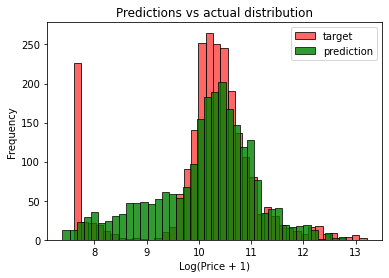

In [34]:
# We can also look at the distribution of the predicted values
plt.figure(figsize=(6, 4))

sns.histplot(y_val, label="target", color="red", alpha=0.6, bins=40)
sns.histplot(y_pred, label="prediction", color="green", alpha=0.8, bins=40)

plt.legend()
plt.xlabel("Log(Price + 1)")
plt.ylabel("Frequency")
plt.title("Predictions vs actual distribution")
plt.show()

Let's do the same for `engine_fuel_type` variable.

In [35]:
df["engine_fuel_type"].value_counts()

regular_unleaded                                7172
premium_unleaded_(required)                     2009
premium_unleaded_(recommended)                  1523
flex-fuel_(unleaded/e85)                         899
diesel                                           154
electric                                          66
flex-fuel_(premium_unleaded_required/e85)         54
flex-fuel_(premium_unleaded_recommended/e85)      26
flex-fuel_(unleaded/natural_gas)                   6
natural_gas                                        2
Name: engine_fuel_type, dtype: int64

In [36]:
def prepare_data_set(df):
  df = df.copy()
  features = features_base.copy()

  # Computes the age feature
  df["age"] = 2017 - df.year
  features.append("age")

  # Encodes the number of doors variable
  for v in [2, 3, 4]:
    feature = f"num_doors_{v}"
    df[feature] = (df["number_of_doors"] == v).astype(int)
    features.append(feature)
  
  # Encodes the make variable
  for v in ["chevrolet", "ford", "volkswagen", "toyota", "dodge"]:
    feature = f"is_make_{v}"
    df[feature] = (df["make"] == v).astype(int)
    features.append(feature)

  # Encodes the engine_fuel_type variable
  for v in ["regular_unleaded", "premium_unleaded_(required)", "premium_unleaded_(recommended)", "flex-fuel_(unleaded/e85)"]:
    feature = f"is_type_{v}"
    df[feature] = (df["engine_fuel_type"] == v).astype(int)
    features.append(feature)

  df_num = df[features]       # selecting features
  df_num = df_num.fillna(0)   # filling the missing values with zero
  X = df_num.values           # converting the DataFrame to a NumPy array
  return X

# Let’s check whether this improves the RMSE of the model
x_train = prepare_data_set(df_train)
w_0, w = train_linear_regression(x_train, y_train)

y_pred = w_0 + x_train.dot(w)
print(f"train: {rmse(y_train, y_pred)}")

x_val = prepare_data_set(df_val)
y_pred = w_0 + x_val.dot(w)
print(f"validation: {rmse(y_val, y_pred)}")

train: 0.4788482615078598
validation: 0.4748256737223095


The previous value was 0.50, so we managed to improve the RMSE score further.

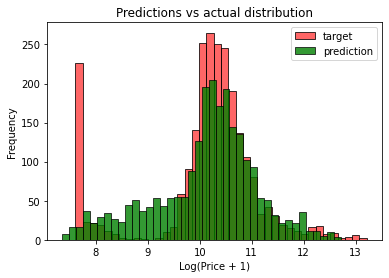

In [37]:
# We can also look at the distribution of the predicted values
plt.figure(figsize=(6, 4))

sns.histplot(y_val, label="target", color="red", alpha=0.6, bins=40)
sns.histplot(y_pred, label="prediction", color="green", alpha=0.8, bins=40)

plt.legend()
plt.xlabel("Log(Price + 1)")
plt.ylabel("Frequency")
plt.title("Predictions vs actual distribution")
plt.show()

Let's do the same for `transmission_type` variable.

In [38]:
df["transmission_type"].value_counts()

automatic           8266
manual              2935
automated_manual     626
direct_drive          68
unknown               19
Name: transmission_type, dtype: int64

In [39]:
def prepare_data_set(df):
  df = df.copy()
  features = features_base.copy()

  # Computes the age feature
  df["age"] = 2017 - df.year
  features.append("age")

  # Encodes the number of doors variable
  for v in [2, 3, 4]:
    feature = f"num_doors_{v}"
    df[feature] = (df["number_of_doors"] == v).astype(int)
    features.append(feature)
  
  # Encodes the make variable
  for v in ["chevrolet", "ford", "volkswagen", "toyota", "dodge"]:
    feature = f"is_make_{v}"
    df[feature] = (df["make"] == v).astype(int)
    features.append(feature)

  # Encodes the engine_fuel_type variable
  for v in ["regular_unleaded", "premium_unleaded_(required)", "premium_unleaded_(recommended)", "flex-fuel_(unleaded/e85)"]:
    feature = f"is_type_{v}"
    df[feature] = (df["engine_fuel_type"] == v).astype(int)
    features.append(feature)

  # Encodes the transmission_type variable
  for v in ["automatic", "manual", "automated_manual"]:
    feature = f"is_transmission_{v}"
    df[feature] = (df["transmission_type"] == v).astype(int)
    features.append(feature)

  df_num = df[features]       # selecting features
  df_num = df_num.fillna(0)   # filling the missing values with zero
  X = df_num.values           # converting the DataFrame to a NumPy array
  return X

# Let’s check whether this improves the RMSE of the model
x_train = prepare_data_set(df_train)
w_0, w = train_linear_regression(x_train, y_train)

y_pred = w_0 + x_train.dot(w)
print(f"train: {rmse(y_train, y_pred)}")

x_val = prepare_data_set(df_val)
y_pred = w_0 + x_val.dot(w)
print(f"validation: {rmse(y_val, y_pred)}")

train: 0.4745380510924003
validation: 0.4685879194658534


The previous value was 0.47, so this time, the RMSE score is not improved further.

Let's do the same for `driven_wheels, market_category, vehicle_size, and vehicle_style` variable.

In [40]:
df["driven_wheels"].value_counts()

front_wheel_drive    4787
rear_wheel_drive     3371
all_wheel_drive      2353
four_wheel_drive     1403
Name: driven_wheels, dtype: int64

In [41]:
df["market_category"].value_counts()

crossover                                          1110
flex_fuel                                           872
luxury                                              855
luxury,performance                                  673
hatchback                                           641
                                                   ... 
crossover,exotic,luxury,performance                   1
exotic,luxury,high-performance,hybrid                 1
crossover,exotic,luxury,high-performance              1
flex_fuel,factory_tuner,luxury,high-performance       1
performance,hybrid                                    1
Name: market_category, Length: 71, dtype: int64

In [42]:
df["vehicle_size"].value_counts()

compact    4764
midsize    4373
large      2777
Name: vehicle_size, dtype: int64

In [43]:
df["vehicle_style"].value_counts()

sedan                  3048
4dr_suv                2488
coupe                  1211
convertible             793
4dr_hatchback           702
crew_cab_pickup         681
extended_cab_pickup     623
wagon                   592
2dr_hatchback           506
passenger_minivan       417
regular_cab_pickup      392
2dr_suv                 138
passenger_van           128
cargo_van                95
cargo_minivan            71
convertible_suv          29
Name: vehicle_style, dtype: int64

In [44]:
def prepare_data_set(df):
  df = df.copy()
  features = features_base.copy()

  # Computes the age feature
  df["age"] = 2017 - df.year
  features.append("age")

  # Encodes the number of doors variable
  for v in [2, 3, 4]:
    feature = f"num_doors_{v}"
    df[feature] = (df["number_of_doors"] == v).astype(int)
    features.append(feature)
  
  # Encodes the make variable
  for v in ["chevrolet", "ford", "volkswagen", "toyota", "dodge"]:
    feature = f"is_make_{v}"
    df[feature] = (df["make"] == v).astype(int)
    features.append(feature)

  # Encodes the engine_fuel_type variable
  for v in ["regular_unleaded", "premium_unleaded_(required)", "premium_unleaded_(recommended)", "flex-fuel_(unleaded/e85)"]:
    feature = f"is_type_{v}"
    df[feature] = (df["engine_fuel_type"] == v).astype(int)
    features.append(feature)

  # Encodes the transmission_type variable
  for v in ["automatic", "manual", "automated_manual"]:
    feature = f"is_transmission_{v}"
    df[feature] = (df["transmission_type"] == v).astype(int)
    features.append(feature)
  
  # Encodes the driven_wheels variable
  for v in ["front_wheel_drive", "rear_wheel_drive", "all_wheel_drive", "four_wheel_drive"]:
    feature = f"is_driven_wheens_{v}"
    df[feature] = (df["driven_wheels"] == v).astype(int)
    features.append(feature)

  # Encodes the market_category variable
  for v in ["crossover", "flex_fuel", "luxury", "luxury,performance", "hatchback"]:
    feature = f"is_mc_{v}"
    df[feature] = (df["market_category"] == v).astype(int)
    features.append(feature)

  # Encodes the vehicle_size variable
  for v in ["compact", "midsize", "large"]:
    feature = f"is_size_{v}"
    df[feature] = (df["vehicle_size"] == v).astype(int)
    features.append(feature)

  # Encodes the vehicle_style variable
  for v in ["sedan", "4dr_suv", "coupe", "convertible", "4dr_hatchback"]:
    feature = f"is_style_{v}"
    df[feature] = (df["vehicle_style"] == v).astype(int)
    features.append(feature)

  df_num = df[features]       # selecting features
  df_num = df_num.fillna(0)   # filling the missing values with zero
  X = df_num.values           # converting the DataFrame to a NumPy array
  return X

# Let’s check whether this improves the RMSE of the model
x_train = prepare_data_set(df_train)
w_0, w = train_linear_regression(x_train, y_train)

y_pred = w_0 + x_train.dot(w)
print(f"train: {rmse(y_train, y_pred)}")

x_val = prepare_data_set(df_val)
y_pred = w_0 + x_val.dot(w)
print(f"validation: {rmse(y_val, y_pred)}")

train: 113.20645472118994
validation: 55.22691647401435


In [45]:
w_0

8115744691019874.0

The number we see is significantly worse than before.

Instead of helping, the new features made the score a lot worse. 

Luckily, we have validation
to help us spot this problem.

##Regularization

Let’s update the linear regression with
regularization.

In [46]:
def train_linear_regression(X, y, alpha=0.0):
  # adding dummy feature into X
  ones = np.ones(X.shape[0])
  X = np.column_stack([ones, X])

  XTX = X.T.dot(X)

  # Adds alpha to the main diagonal of XTX
  reg = alpha * np.eye(XTX.shape[0])
  XTX = XTX + reg

  XTX_inv = np.linalg.inv(XTX)
  w = XTX_inv.dot(X.T).dot(y)
  # Splits the weights vector into the bias and the rest of the weights
  return w[0], w[1:]

In [50]:
# Let’s check what happens with our weights for different values of alpha
x_train = prepare_data_set(df_train)

for alpha in [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
  w_0, w = train_linear_regression(x_train, y_train, alpha=alpha)
  print(f"{alpha}\t {w_0:.2f}, {w[13]:.2f}, {w[21]:.2f}")

0,	 8115744691019874.00, -7.10, -8115744691023588.00
0.0001,	 7.26, -0.10, 1.75
0.001,	 7.20, -0.10, 1.81
0.01,	 7.18, -0.10, 1.81
0.1,	 7.05, -0.10, 1.78
1,	 6.22, -0.10, 1.56
10,	 4.39, -0.09, 1.08
100,	 2.52, -0.08, 0.62
1000,	 0.78, -0.04, 0.25
10000,	 0.13, -0.01, 0.06


Now let’s check whether regularization helps with our problem.

In [51]:
# alpha=0.0001
x_train = prepare_data_set(df_train)
w_0, w = train_linear_regression(x_train, y_train, alpha=0.0001)

y_pred = w_0 + x_train.dot(w)
print(f"train: {rmse(y_train, y_pred)}")

x_val = prepare_data_set(df_val)
y_pred = w_0 + x_val.dot(w)
print(f"validation: {rmse(y_val, y_pred)}")

train: 0.46431213118144193
validation: 0.4602254931319512


In [52]:
# alpha=0.001
x_train = prepare_data_set(df_train)
w_0, w = train_linear_regression(x_train, y_train, alpha=0.001)

y_pred = w_0 + x_train.dot(w)
print(f"train: {rmse(y_train, y_pred)}")

x_val = prepare_data_set(df_val)
y_pred = w_0 + x_val.dot(w)
print(f"validation: {rmse(y_val, y_pred)}")

train: 0.46431213476958777
validation: 0.4602267628312077


In [53]:
# alpha=0.01
x_train = prepare_data_set(df_train)
w_0, w = train_linear_regression(x_train, y_train, alpha=0.01)

y_pred = w_0 + x_train.dot(w)
print(f"train: {rmse(y_train, y_pred)}")

x_val = prepare_data_set(df_val)
y_pred = w_0 + x_val.dot(w)
print(f"validation: {rmse(y_val, y_pred)}")

train: 0.464312489456461
validation: 0.4602394963124682


In [54]:
# alpha=0.1
x_train = prepare_data_set(df_train)
w_0, w = train_linear_regression(x_train, y_train, alpha=0.1)

y_pred = w_0 + x_train.dot(w)
print(f"train: {rmse(y_train, y_pred)}")

x_val = prepare_data_set(df_val)
y_pred = w_0 + x_val.dot(w)
print(f"validation: {rmse(y_val, y_pred)}")

train: 0.4643444223633168
validation: 0.4603700695819783


This result is an improvement over the previous score: 0.507.

Let’s try a couple of different
ones to select the best parameter alpha.

In [55]:
x_train = prepare_data_set(df_train)
x_val = prepare_data_set(df_val)

for alpha in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
  w_0, w = train_linear_regression(x_train, y_train, alpha=alpha)
  y_pred = w_0 + x_val.dot(w)
  print(f"{alpha}\t {rmse(y_val, y_pred)}")

1e-06	 0.4602251277547402
0.0001	 0.4602254931319512
0.001	 0.4602267628312077
0.01	 0.4602394963124682
0.1	 0.4603700695819783
1	 0.4618298042652329
5	 0.46840796275321883
10	 0.4757248100695211


>Sometimes, when adding a new feature causes performance degradation,
simply removing this feature may be enough to solve the problem. Having
a validation dataset is important to decide whether to add regularization,
remove the feature, or do both: we use the score on the validation data to
choose the best option. In our particular case, we see that adding regularization helps: it improves the score we had previously.

We also notice that the performance for values below 0.1 don’t change much except in the sixth digit, which we shouldn’t consider to be significant.

Let’s take the model with `alpha=0.01` as the final model.

In [57]:
x_train = prepare_data_set(df_train)
w_0, w = train_linear_regression(x_train, y_train, alpha=0.01)

y_pred = w_0 + x_train.dot(w)
print(f"train: {rmse(y_train, y_pred)}")

x_val = prepare_data_set(df_val)
y_pred = w_0 + x_val.dot(w)
print(f"validation: {rmse(y_val, y_pred)}")

x_test = prepare_data_set(df_test)
y_pred = w_0 + x_test.dot(w)
print(f"test: {rmse(y_test, y_pred)}")

train: 0.464312489456461
validation: 0.4602394963124682
test: 0.4571813679271304


**Because the validation and test score are pretty close, we conclude that the model can generalize well to the new unseen data.**

##Using the model